In [1]:
# Packages that make working with data easier
import os
from astropy.io import fits
import tensorflow as tf
import pandas as pd
import numpy as np
import h5py

#Vsualization 
import matplotlib.pyplot as plt

#Data pre-processing
from DataMaker import *

#Keras Models
import keras
from keras.models import Sequential ,Model
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, LeakyReLU, Dense, Input, Dropout, Flatten, GlobalAveragePooling2D, Dropout, Concatenate
from keras.utils import plot_model
from keras.layers import SpatialDropout2D

2023-09-14 12:07:59.347916: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 12:08:00.134598: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-09-14 12:08:00.134795: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-09-14 12:08:00.134799: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
!nvidia-smi

Thu Sep 14 12:08:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:61:00.0  On |                  Off |
| 30%   37C    P8    25W / 300W |   1184MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  # Restrict TensorFlow to only allocate 10GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=20000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
# Path to where the HSC ML Dataset images and metadata are stored and split into training, validation, and testing
start_path = '/data3/Jonathan/five_band_image127x127_with_metadata_'
TRAIN_PATH = start_path + 'training.hdf5'
TEST_PATH  = start_path + 'testing.hdf5'
VAL_PATH   = start_path + 'validation.hdf5'

# Shape of our images
IMAGE_SHAPE = (5,127,127)

# Output we are interested 
y_key = 'ishape_hsm_regauss_e1'

In [5]:
'''
    A dictionary of arguments used of HDF5 Image Generator from the DataMaker package 
        x_key: the input for the model; grizy-band images from the HDF5 file labeled 'image'
        y_key: the output for the model; as defined above
        scaler: scales the input
        y_scaler: scales the output; options minmax, standard, or False (for none)
        y_range: for minmax a range for values must be specified. 
        labels_encoding: not applicable for regression
        batch_size: number of images and output opened at once by the HDF5ImageGenerator
        mode: returns output and input 
'''
args_gen = {'X_key': 'image',
            'y_key': y_key,
            'scaler': False,
            'y_scaler': 'minmax',
            'y_range': (0,1),
            'labels_encoding': False,
            'batch_size': 32,
            'mode': 'train'}



In [6]:
#Same as above except we don't shuffle. it makes 1-1 comparison of predictions difficult later on if we do shuffle

args_gen_test = {'X_key': 'image',
            'y_key': y_key,
            'scaler': False,
            'y_scaler': 'minmax',
            'y_range': (0,1),
            'labels_encoding': False,
            'batch_size': 32,
            'shuffle': False,
            'mode': 'train'}

In [7]:
#Import HSC Data
train = HDF5ImageGenerator(src=TRAIN_PATH, **args_gen)
test  = HDF5ImageGenerator(src=TEST_PATH, **args_gen_test)
val   = HDF5ImageGenerator(src=VAL_PATH, **args_gen)

In [1]:
# Code used to plot distributions

# with h5.File(TEST_PATH, "r") as file:
#     field = np.array(file['field'])

# plt.figure(figsize=(10,6))
# plt.hist(field, density=True,alpha=0.7, color='blue')
# plt.ylabel('Field Type')
# plt.xlabel('Frequency')
# plt.title('Distribution of Galaxies Per Field: Test Set')
# plt.show()

In [11]:
# This code does the same as above commented code except it maekes use of HDF5 image generator methods
# __len__() returns number of batches 
#__getitem__(#) returns image and/or output with (#) signifying the element and [0] for image or [1] for output, [0][0] would signify g-band of images
e1train = []
for i in range(0, train.__len__()):
    e1train = np.append(e1train, train.__getitem__(i)[1])

    
e1test = []
for i in range(0, test.__len__()):
    e1test = np.append(e1test, test.__getitem__(i)[1])
    
e1val = []
for i in range(0, val.__len__()):
    e1val = np.append(e1val, val.__getitem__(i)[1])

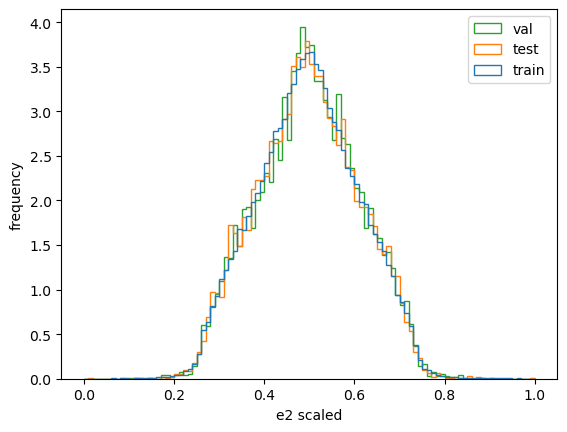

In [12]:
plt.hist([e1train, e1test, e1val], density=True, bins = 100, histtype='step', label=['train', 'test', 'val'])
plt.xlabel('e1 scaled')
plt.ylabel('frequency')
plt.legend()
plt.show()

In [2]:
#VGG 19 Architecture

input_ = Input(shape=(5, 127, 127))

#First Convolution Layer
conv1  = Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', data_format='channels_first')(input_)
bn1    = BatchNormalization()(conv1)
conv2  = Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', data_format='channels_first')(bn1)
bn2    = BatchNormalization()(conv2)
pool2  = MaxPooling2D(pool_size=(2,2), data_format='channels_first')(bn2)

#Second Convolution Layer
conv3  = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same', data_format='channels_first')(pool2)
bn3    = BatchNormalization()(conv3)
conv4  = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same', data_format='channels_first')(bn3)
bn4    = BatchNormalization()(conv4)
pool4  = MaxPooling2D(pool_size=(2,2), data_format='channels_first')(bn4)

#Third Convolution Layer
conv5  = Conv2D(256, kernel_size=(3,3), activation='relu', padding='same', data_format='channels_first')(pool4)
bn5    = BatchNormalization()(conv5)
conv6  = Conv2D(256, kernel_size=(3,3), activation='relu', padding='same', data_format='channels_first')(bn5)
bn6    = BatchNormalization()(conv6)
conv7  = Conv2D(256, kernel_size=(3,3), activation='relu', padding='same', data_format='channels_first')(bn6)
bn7    = BatchNormalization()(conv7)
conv14 = Conv2D(256, kernel_size=(3,3), activation='relu', padding='same', data_format='channels_first')(bn7)
bn14   = BatchNormalization()(conv14)
pool7  = MaxPooling2D(pool_size=(2,2), data_format='channels_first')(bn14)

#Fourth Convolution Layer
conv8  = Conv2D(512, kernel_size=(3,3), activation='relu', padding='same', data_format='channels_first')(pool7)
bn8    = BatchNormalization()(conv8) 
conv9  = Conv2D(512, kernel_size=(3,3), activation='relu', padding='same', data_format='channels_first')(bn8)
bn9    = BatchNormalization()(conv9)
conv10 = Conv2D(512, kernel_size=(3,3), activation='relu', padding='same', data_format='channels_first')(bn9)
bn10   = BatchNormalization()(conv10)
conv15 = Conv2D(512, kernel_size=(3,3), activation='relu', padding='same', data_format='channels_first')(bn10)
bn15   = BatchNormalization()(conv15)
pool10 = MaxPooling2D(pool_size=(2,2), data_format='channels_first')(bn15)

#Fifth Convolution Layer
conv11  = Conv2D(1024, kernel_size=(3,3), activation='relu', padding='same', data_format='channels_first')(pool10)
bn11    = BatchNormalization()(conv11)
conv12  = Conv2D(1024, kernel_size=(3,3), activation='relu', padding='same', data_format='channels_first')(bn11)
bn12    = BatchNormalization()(conv12)
conv13  = Conv2D(1024, kernel_size=(3,3), activation='relu', padding='same', data_format='channels_first')(bn12)
bn13    = BatchNormalization()(conv13)
conv16 = Conv2D(1024, kernel_size=(3,3), activation='relu', padding='same', data_format='channels_first')(bn13)
bn16   = BatchNormalization()(conv16)
conv17 = Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first')(bn16)
bn17 = BatchNormalization()(conv17)
conv18 = Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first')(bn17)
bn18 = BatchNormalization()(conv18)
conv19 = Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first')(bn18)
bn19 = BatchNormalization()(conv19)
conv20 = Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first')(bn19)
bn20 = BatchNormalization()(conv20)
pool14 = MaxPooling2D(pool_size=(2, 2), data_format='channels_first')(bn20)


#Fully Connected Layer
flatten = Flatten()(pool14)
dense1  = Dense(512, activation='relu')(flatten)
drop1   = Dropout(0.5)(dense1)

#Output
output = Dense(1, activation='relu')(drop1)

model = Model(inputs=[input_], outputs=[output], name='vgg19')
model.summary()

NameError: name 'Input' is not defined

In [10]:
#GoogLe Net architecture

#Code for the inception module
def Inception(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4):
    # Input: 
    # - f1: number of filters of the 1x1 convolutional layer in the first path
    # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
    # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
    # - f4: number of filters of the 1x1 convolutional layer in the fourth path

    # 1st path:
    path1 = conv_mod(input_layer, f1, kernel_size = (1,1), padding = 'same', activation = 'relu', data_format='channels_first')

    # 2nd path
    path2 = conv_mod(input_layer, f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu', data_format='channels_first')
    path2 = conv_mod(path2, f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu', data_format='channels_first')

    # 3rd path
    path3 = conv_mod(input_layer, f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu', data_format='channels_first')
    path3 = conv_mod(path3, f3_conv5, kernel_size = (2,2), padding = 'same', activation = 'relu', data_format='channels_first')

    # 4th path
    path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same', data_format='channels_first')(input_layer)
    path4 = conv_mod(path4, f4, kernel_size = (1,1), padding = 'same', activation = 'relu', data_format='channels_first')

    output_layer = Concatenate(axis=1)([path1, path2, path3, path4])

    return output_layer

#Small block to perform convolution and batch normalization
def conv_mod(input_layer, f1, **kwargs):
    conv = Conv2D(filters=f1, **kwargs)(input_layer)
    return BatchNormalization()(conv)


# Input Layer
input_layer = Input(shape=(5, 127, 127))

#Convolution layer: filters=64, 7x7 kernel, strides=2
conv1 = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu', data_format='channels_first')(input_layer)
pool1 = MaxPooling2D(pool_size=(3,3), strides=2, padding='same', data_format='channels_first')(conv1)
bn1   = BatchNormalization()(pool1)

#Convolution layer 2: filters=64, strides=1
conv2 = conv_mod(bn1, 64, kernel_size=(1,1), strides=1, padding='same', activation='relu', data_format='channels_first')

#Convolution layer 3: filters=192, kernel_size=(3,3)
conv3 = conv_mod(conv2, 192, kernel_size=(3,3), padding='same', activation='relu', data_format='channels_first')
pool3 = MaxPooling2D(pool_size=(3,3), strides=2, padding='same', data_format='channels_first')(conv3)

#Inception BLock 1
incept1 = Inception(pool3, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

#Incept Block 2
incept2 = Inception(incept1, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)
pool4   = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(incept2)

#Incept Block 3 
incept3 = Inception(pool4, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

# Extra network 1:
apool1 = AveragePooling2D(pool_size = (5,5), strides = 3)(incept3)
conv4  = conv_mod(apool1, 512, kernel_size = (1,1), padding = 'same', activation = 'relu')
flatten1 = Flatten()(conv4)
dense1 = Dense(512, activation = 'relu')(flatten1)
drop1 = Dropout(0.7)(dense1)
dense1 = Dense(1, activation='relu', name='aux1')(drop1)

# 4th Inception block
incept4 = Inception(incept3, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

# 5th Inception block
incept5 = Inception(incept4, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

# 6th Inception block
incept6 = Inception(incept5, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

# Extra network 2:
apool2 = AveragePooling2D(pool_size = (5,5), strides = 3)(incept6)
conv5 = conv_mod(apool2, 512, kernel_size = (1,1), padding = 'same', activation = 'relu')
flatten2 = Flatten()(conv5)
dense2 = Dense(512, activation = 'relu')(flatten2)
drop2 = Dropout(0.7)(dense2)
dense2 = Dense(1, activation = 'relu', name='aux2')(drop2)


# 7th Inception block
incept7 = Inception(incept6, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

# max-pooling layer: pool_size = (3,3), strides = 2
pool5 = MaxPooling2D(pool_size = (3,3), strides = 2, padding='same')(incept7)

# 8th Inception block
incept8 = Inception(pool5, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

# 9th Inception block
incept9 = Inception(incept8, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

# Global Average pooling layer 
gapool = AveragePooling2D(name = 'GAPL')(incept9)

# FC 
flatten = Flatten()(gapool)
dense = Dense(512, activation='relu')(flatten)
drop  = Dropout(0.7)(dense)

# output layer 
output_layer = Dense(1, activation='relu', name='main_output')(drop)

# model
model = Model(input_layer, [output_layer, dense1, dense2], name = 'GoogLeNet')
model.summary()

In [9]:
!nvidia-smi

Mon Sep 11 15:48:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:61:00.0  On |                  Off |
| 30%   42C    P2    71W / 300W |  21626MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
#Setting up learning rate/optimizer at 5e-6 and callbacks
optimizer = tf.keras.optimizers.Adam(learning_rate=0.000005)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=10)
callback2 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience = 5)

#Compile model learning on MSE with MAE also being reported for reference
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError()])

#fit the model for 200 epochs
history = model.fit(train, epochs=200, shuffle = True, validation_data = val, verbose = 1, callbacks=[callback, callback2])#, callbacks=[cp_callback])


Epoch 1/200
2500/2500 [==============================] - 258s 99ms/step - loss: 0.2615 - mean_absolute_error: 0.4975 - mean_squared_error: 0.2615 - val_loss: 0.2609 - val_mean_absolute_error: 0.4984 - val_mean_squared_error: 0.2609 - lr: 5.0000e-04
Epoch 2/200
2500/2500 [==============================] - 244s 97ms/step - loss: 0.2595 - mean_absolute_error: 0.4970 - mean_squared_error: 0.2595 - val_loss: 0.2609 - val_mean_absolute_error: 0.4984 - val_mean_squared_error: 0.2609 - lr: 5.0000e-04
Epoch 3/200
2500/2500 [==============================] - 243s 97ms/step - loss: 0.2595 - mean_absolute_error: 0.4970 - mean_squared_error: 0.2595 - val_loss: 0.2609 - val_mean_absolute_error: 0.4984 - val_mean_squared_error: 0.2609 - lr: 5.0000e-04
Epoch 4/200
2500/2500 [==============================] - 244s 97ms/step - loss: 0.2595 - mean_absolute_error: 0.4970 - mean_squared_error: 0.2595 - val_loss: 0.2609 - val_mean_absolute_error: 0.4984 - val_mean_squared_error: 0.2609 - lr: 5.0000e-04
Epoc

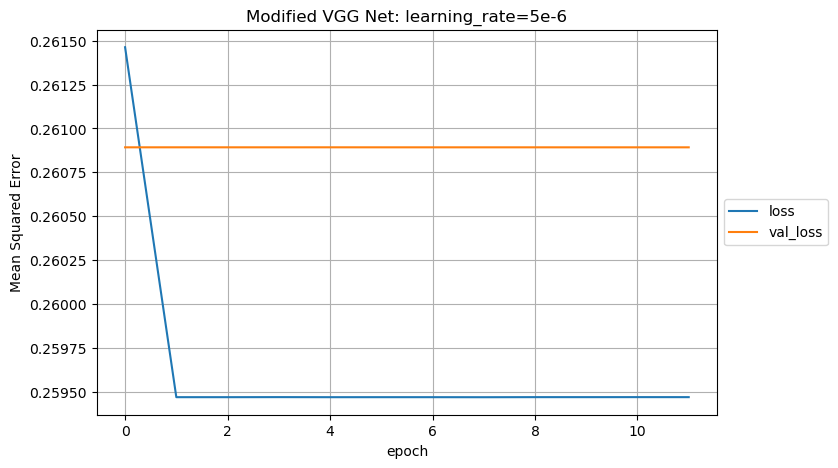

In [12]:
#Plot the learning curves for teh loss and validation loss

pd.DataFrame(history.history)[['loss','val_loss']].plot(figsize=(8,5))
plt.grid(True)

plt.xlabel('epoch')
plt.ylabel('Mean Squared Error')
plt.title('Modified VGG Net: learning_rate=5e-6')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.gca().set_ylim(0,1)
plt.show()

Evaluation and Predictions

In [13]:
model.evaluate(test)

313/313 [==============================] - 9s 30ms/step - loss: 0.2587 - mean_absolute_error: 0.4962 - mean_squared_error: 0.2587


[0.25872278213500977, 0.496167927980423, 0.25872278213500977]

In [14]:
predictions = model.predict(test)

313/313 [==============================] - 8s 26ms/step


In [14]:
predictions

array([[0.45416492],
       [0.5252579 ],
       [0.48922598],
       ...,
       [0.5266793 ],
       [0.4687491 ],
       [0.43426102]], dtype=float32)

In [15]:
#Get the known outputs for the galaxies predicted above and sort them to match with predictions

hf_test = h5py.File(TEST_PATH, 'r')
y_test = hf_test[y_key][np.sort(test._indices)]
objID_test = hf_test['object_id'][np.sort(test._indices)]
hf_test.close()

In [16]:
objID_test[0]

36411452835235898

In [16]:
#Revert back to no scale for the e1 values
predictions = train.inverse_transform_labels(predictions)

[[-1.9298879]
 [-1.9298879]
 [-1.9298879]
 ...
 [-1.9298879]
 [-1.9298879]
 [-1.9298879]]


In [17]:
#Flatten the real e1 values for plotting ease
y_test = np.array(y_test).flatten()

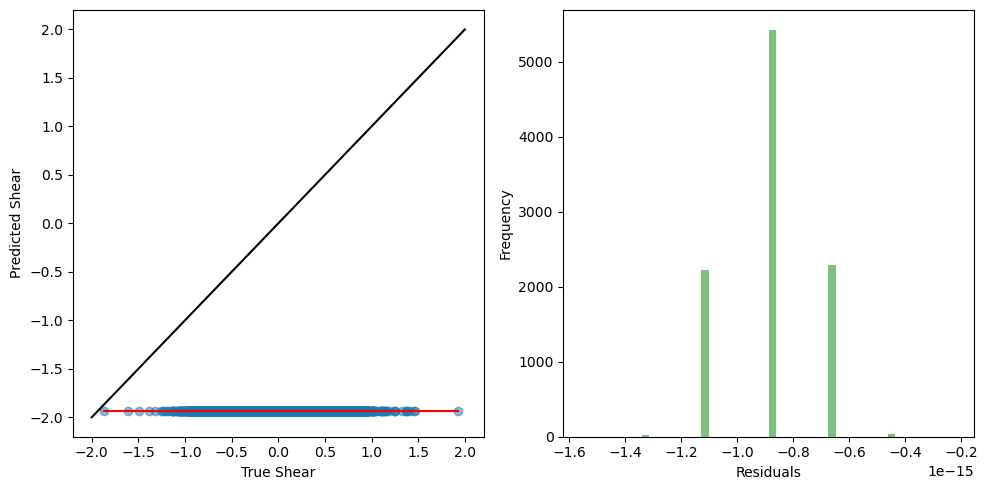

Multiplicative bias (m-1): -0.9999999999999997
Additive bias (c): -1.929887890815734


In [18]:
#Make a plot with the real vs predicted e1 values along with the multiplicative and additive bias. Also plot the residuals

slope, intercept = np.polyfit(y_test, predictions.flatten(), 1)

# Compute the biases
multiplicative_bias = slope - 1
additive_bias = intercept

# Plot the biases
plt.figure(figsize=(10, 5))

# Scatter plot of true vs predicted shear values
plt.subplot(1, 2, 1)
plt.scatter(y_test, predictions.flatten(), alpha=0.5)
x = np.linspace(min(y_test), max(y_test), 100)
plt.plot(x, slope*x + intercept, 'r')
x2 = np.linspace(-2, 2, 100)
plt.plot(x2, x2, 'black') 
plt.xlabel('True Shear')
plt.ylabel('Predicted Shear')

# Histogram of residuals
plt.subplot(1, 2, 2)
plt.hist(predictions.flatten() - (slope*y_test + intercept), bins=50, color='g', alpha=0.5)
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"Multiplicative bias (m-1): {multiplicative_bias}")
print(f"Additive bias (c): {additive_bias}")

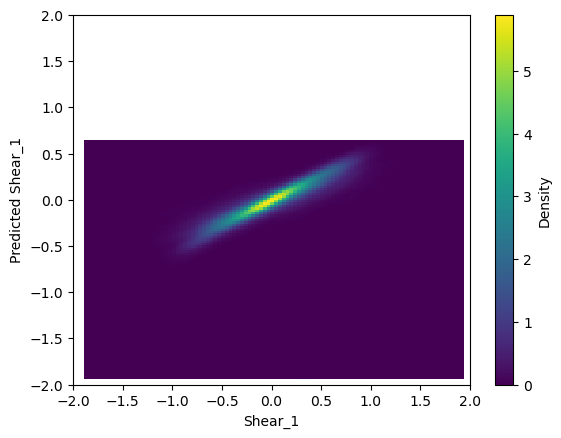

In [21]:
#Another representation of predictions and real e1 values

from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt

# predictions = model.predict([x_test])
# photoz = [pred[0] for pred in predictions]

# Create a 2D array of the data
data = np.vstack([y_test, predictions.flatten()])

# Calculate the Gaussian KDE
kde = gaussian_kde(data)

# Create a grid over which to evaluate the KDE
xgrid, ygrid = np.meshgrid(np.linspace(np.min(y_test), np.max(y_test), 100), 
                           np.linspace(np.min(predictions.flatten()), np.max(predictions.flatten()), 100))

# Evaluate the KDE on the grid
z = kde.evaluate(np.vstack([xgrid.ravel(), ygrid.ravel()]))

# Reshape the result back into 2D
z = z.reshape(xgrid.shape)

# Plot the result
plt.pcolormesh(xgrid, ygrid, z, shading='auto')
plt.colorbar(label='Density')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.ylabel('Predicted Shear_1')
plt.xlabel('Shear_1')
plt.show()
